# bert-base-uncased

In [2]:
from deep_translator import GoogleTranslator
import pandas as pd


df = pd.read_csv("final_data.csv")[["text", "LABEL"]].rename(
    columns={"text": "phrase", "LABEL": "label"}
)
sample_df = df.sample(10, random_state=42).reset_index(drop=True)

# Translate English to Chinese
sample_df["translated_phrase"] = sample_df["phrase"].apply(
    lambda x: GoogleTranslator(source="en", target="zh-CN").translate(x)
)

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model_path = "bert_output"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Tokenize Chinese text (zero-shot)
inputs = tokenizer(
    sample_df["translated_phrase"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
)

with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

In [4]:
# Your label mapping
id2label = {
    0: "Neurological & General Symptoms",
    1: "Dermatological & Skin Conditions",
    2: "Chronic Conditions",
    3: "Infections",
    4: "Pain-related Conditions",
    5: "Respiratory & Sensory Issues",
    6: "Gastrointestinal Conditions",
    7: "Allergic/Immunologic Reactions",
    8: "Hepatobiliary",
    9: "Trauma/Injuries",
}

# Add predictions to your dataframe
sample_df["predicted_label"] = [id2label[p.item()] for p in predictions]

# Show results
sample_df[["phrase", "translated_phrase", "label", "predicted_label"]]

,phrase,translated_phrase,label,predicted_label
0,"Blood is in my pee, and I have a low body temp...",血液在我的小便中，体温低。我实际上有着持续的头痛，通常很强，无法控制的是小便的需求。此外，我...,Infections,Allergic/Immunologic Reactions
1,My ear ache when I'm listening to music.,当我听音乐时，我的耳朵疼。,Respiratory & Sensory Issues,Neurological & General Symptoms
2,I have slow healing of wounds and cuts. I have...,我的伤口和切割疗法缓慢。我的手里有这种刺痛感，手和脚上的麻木,Chronic Conditions,Neurological & General Symptoms
3,I have a sharp pain in my neck,我的脖子剧烈疼痛,Pain & Injuries,Neurological & General Symptoms
4,I have a runny nose and I am sneezing all the ...,我的鼻子流鼻涕，一直在打喷嚏。我的眼睛发痒且经常水，我一直在咳嗽。我的头一直很痛,Allergic/Immunologic Reactions,Allergic/Immunologic Reactions
5,I'm having problems breathing and have a very ...,我呼吸困难，发高烧。我很汗，经历了极端的疲劳和寒冷。我的心正在赛车，我正在咳嗽一些褐色的粘液。,Infections,Allergic/Immunologic Reactions
6,"its been a week , i am suffering from continio...",已经有一个星期了，我正遭受持续的健康问题，例如干咳嗽，呼吸问题，全天疲软。,Respiratory & Sensory Issues,Neurological & General Symptoms
7,I have a nasal congestion and blocked nose. So...,我有鼻塞和鼻子阻塞。有时候，晚上我会感到胸痛和紧绷。我也失去了气味和味道,Allergic/Immunologic Reactions,Neurological & General Symptoms
8,"Blurred or hazy vision, eye pain or discomfort...",视力模糊或朦胧，眼睛疼痛或不适，眼睛发红或刺激，撕裂过度，对光的敏感（恐惧症），异物体内感觉...,NaN,Allergic/Immunologic Reactions
9,"Back pain, a dry cough, and a lack of muscle s...",背痛，干咳嗽以及缺乏肌肉力量困扰着我。我的脖子很痛，我一直感到头昏眼花和发抖。,Chronic Conditions,Allergic/Immunologic Reactions


In [5]:
import pandas as pd
from datasets import Dataset

# Load and preprocess your English-labeled data
df = pd.read_csv("final_data.csv")[["text", "LABEL"]]
df = df.rename(columns={"text": "phrase", "LABEL": "label"})

# Encode labels
unique_labels = df["label"].unique().tolist()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
df["label_id"] = df["label"].map(label2id)

# Train-test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_ds = Dataset.from_pandas(train_df[["phrase", "label_id"]])
test_ds = Dataset.from_pandas(test_df[["phrase", "label_id"]])

# bert-base-multilingual

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")


def tokenize_function(example):
    return tokenizer(
        example["phrase"], padding="max_length", truncation=True, max_length=128
    )


train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

train_ds = train_ds.rename_column("label_id", "labels")
test_ds = test_ds.rename_column("label_id", "labels")
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/1844 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

In [7]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", num_labels=len(label2id)
)

training_args = TrainingArguments(
    output_dir="./multilingual_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
trainer.train()
trainer.save_model("multilingual_output")

  0%|          | 0/693 [00:00<?, ?it/s]

{'loss': 1.897, 'grad_norm': 14.632686614990234, 'learning_rate': 4.6392496392496395e-05, 'epoch': 0.22}
{'loss': 1.5487, 'grad_norm': 7.708217144012451, 'learning_rate': 4.278499278499279e-05, 'epoch': 0.43}
{'loss': 1.3158, 'grad_norm': 17.75469398498535, 'learning_rate': 3.917748917748918e-05, 'epoch': 0.65}
{'loss': 1.0466, 'grad_norm': 18.448284149169922, 'learning_rate': 3.556998556998557e-05, 'epoch': 0.87}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.7399147152900696, 'eval_accuracy': 0.7878787878787878, 'eval_f1': 0.7726597558517446, 'eval_runtime': 4.57, 'eval_samples_per_second': 101.094, 'eval_steps_per_second': 12.691, 'epoch': 1.0}
{'loss': 0.8555, 'grad_norm': 17.565513610839844, 'learning_rate': 3.1962481962481965e-05, 'epoch': 1.08}
{'loss': 0.6626, 'grad_norm': 18.814144134521484, 'learning_rate': 2.8354978354978357e-05, 'epoch': 1.3}
{'loss': 0.6422, 'grad_norm': 12.094751358032227, 'learning_rate': 2.474747474747475e-05, 'epoch': 1.52}
{'loss': 0.4267, 'grad_norm': 15.465435028076172, 'learning_rate': 2.113997113997114e-05, 'epoch': 1.73}
{'loss': 0.4839, 'grad_norm': 3.4488205909729004, 'learning_rate': 1.7532467532467535e-05, 'epoch': 1.95}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.5257003307342529, 'eval_accuracy': 0.8571428571428571, 'eval_f1': 0.8568147638013891, 'eval_runtime': 4.7975, 'eval_samples_per_second': 96.3, 'eval_steps_per_second': 12.09, 'epoch': 2.0}
{'loss': 0.373, 'grad_norm': 1.1927714347839355, 'learning_rate': 1.3924963924963927e-05, 'epoch': 2.16}
{'loss': 0.3151, 'grad_norm': 21.020137786865234, 'learning_rate': 1.0317460317460318e-05, 'epoch': 2.38}
{'loss': 0.3248, 'grad_norm': 26.85758399963379, 'learning_rate': 6.709956709956711e-06, 'epoch': 2.6}
{'loss': 0.3181, 'grad_norm': 0.4657944440841675, 'learning_rate': 3.1024531024531023e-06, 'epoch': 2.81}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.4843892753124237, 'eval_accuracy': 0.8701298701298701, 'eval_f1': 0.8705672009974252, 'eval_runtime': 4.6729, 'eval_samples_per_second': 98.867, 'eval_steps_per_second': 12.412, 'epoch': 3.0}
{'train_runtime': 265.9514, 'train_samples_per_second': 20.801, 'train_steps_per_second': 2.606, 'train_loss': 0.7528558527408397, 'epoch': 3.0}


In [9]:
# Evaluate model on the English validation set
results = trainer.evaluate()
print(results)

  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.4843892753124237, 'eval_accuracy': 0.8701298701298701, 'eval_f1': 0.8705672009974252, 'eval_runtime': 4.4432, 'eval_samples_per_second': 103.98, 'eval_steps_per_second': 13.054, 'epoch': 3.0}


# Run Zero-Shot Inference on Chinese Text with Your Multilingual Model

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model_path = "multilingual_output"
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [11]:
# Tokenize and predict
inputs = tokenizer(
    sample_df["translated_phrase"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
)

with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

In [12]:
# Label mapping (rebuild from training)
unique_labels = df["label"].unique().tolist()
id2label = {i: label for i, label in enumerate(unique_labels)}

# Add predictions to DataFrame
sample_df["predicted_label"] = [id2label[p.item()] for p in predictions]

# Show results
sample_df[["phrase", "translated_phrase", "label", "predicted_label"]]

,phrase,translated_phrase,label,predicted_label
0,"Blood is in my pee, and I have a low body temp...",血液在我的小便中，体温低。我实际上有着持续的头痛，通常很强，无法控制的是小便的需求。此外，我...,Infections,Infections
1,My ear ache when I'm listening to music.,当我听音乐时，我的耳朵疼。,Respiratory & Sensory Issues,Respiratory & Sensory Issues
2,I have slow healing of wounds and cuts. I have...,我的伤口和切割疗法缓慢。我的手里有这种刺痛感，手和脚上的麻木,Chronic Conditions,Allergic/Immunologic Reactions
3,I have a sharp pain in my neck,我的脖子剧烈疼痛,Pain & Injuries,Pain & Injuries
4,I have a runny nose and I am sneezing all the ...,我的鼻子流鼻涕，一直在打喷嚏。我的眼睛发痒且经常水，我一直在咳嗽。我的头一直很痛,Allergic/Immunologic Reactions,Allergic/Immunologic Reactions
5,I'm having problems breathing and have a very ...,我呼吸困难，发高烧。我很汗，经历了极端的疲劳和寒冷。我的心正在赛车，我正在咳嗽一些褐色的粘液。,Infections,Infections
6,"its been a week , i am suffering from continio...",已经有一个星期了，我正遭受持续的健康问题，例如干咳嗽，呼吸问题，全天疲软。,Respiratory & Sensory Issues,Neurological & General Symptoms
7,I have a nasal congestion and blocked nose. So...,我有鼻塞和鼻子阻塞。有时候，晚上我会感到胸痛和紧绷。我也失去了气味和味道,Allergic/Immunologic Reactions,Allergic/Immunologic Reactions
8,"Blurred or hazy vision, eye pain or discomfort...",视力模糊或朦胧，眼睛疼痛或不适，眼睛发红或刺激，撕裂过度，对光的敏感（恐惧症），异物体内感觉...,NaN,NaN
9,"Back pain, a dry cough, and a lack of muscle s...",背痛，干咳嗽以及缺乏肌肉力量困扰着我。我的脖子很痛，我一直感到头昏眼花和发抖。,Chronic Conditions,Allergic/Immunologic Reactions


**We fine-tuned bert-base-multilingual-cased on 1,900 English-labeled medical symptom examples. We then evaluated the model on Chinese-translated versions of those examples, without any fine-tuning on Chinese data. The model correctly classified most inputs, achieving strong semantic generalization across languages. These results demonstrate the power of multilingual transformers for cross-lingual medical text classification in a zero-shot setting.**



# Confusion Matrix

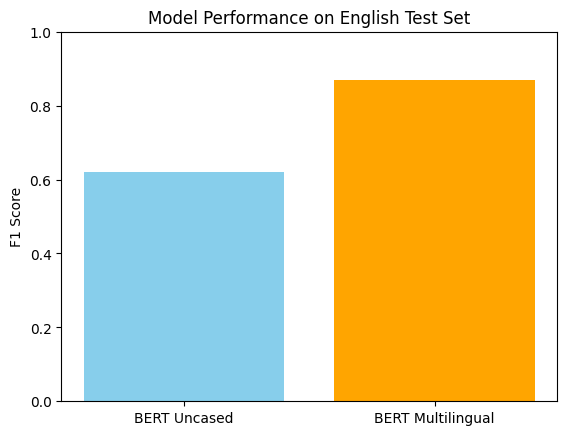

In [16]:
import matplotlib.pyplot as plt

models = ["BERT Uncased", "BERT Multilingual"]
f1_scores = [0.62, 0.87]  # Update with your actual uncased F1 if known

plt.bar(models, f1_scores, color=["skyblue", "orange"])
plt.ylabel("F1 Score")
plt.title("Model Performance on English Test Set")
plt.ylim(0, 1)
plt.show()